#### Colab Link
    https://colab.research.google.com/drive/1xRLI0yjkePhzGk8flStg5p8Romidf6I-?usp=sharing

#### Reference

    1. Efficient learning of non-autoregressive graph variational autoencoders for molecular graph generation, 2019 ( https://jcheminf.biomedcentral.com/counter/pdf/10.1186/s13321-019-0396-x.pdf )
        ✔ Variational Autoencoder를 포함하는 학습 방법을 사용하여 분자 그래프 생성의 전반적인 효율성과 성능 개선


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install wandb
!pip install deepchem
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=87565be77b837a263bb9ca198734ac8515bf071f24284bbdeb09a71a1c7615d6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.

In [ ]:
import argparse
import sys
import yaml
import json
import os
import joblib
import networkx as nx
import pickle as pkl
from tqdm import tqdm
from datetime import datetime
import time
import random
import copy
from collections import OrderedDict, defaultdict
import warnings
from prettytable import PrettyTable
import wandb

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw, AllChem, Descriptors
from rdkit.Chem.Crippen import MolLogP
import deepchem as dc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

import torchvision
import torchvision.transforms as transforms

os.environ['TORCH'] = torch.__version__
print(f'Torch ver. : {torch.__version__}')

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Torch ver. : 2.0.1+cu118


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dropout, to_dense_adj, dense_to_sparse, remove_self_loops
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, Set2Set, BatchNorm
# global_mean_pool :  readout에서 각 노드의 node feature vector들이 남게 되는데, 이걸 하나의 feature로 표현하기 위해 사용
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.conv import TransformerConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
ENTITY = 'rossi22'
TRAIN_PROJECT = 'GRAPH_VAE_TRAIN'

DEFAULT_PARAMS = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'learning_rate': 5e-6,
    'epochs': 30,
    'period': 1,

    'supported_edges': ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"],
    'supported_atoms':  ['C','N','O','F', 'None' ],
    'atomic_numbers':[6, 7, 8, 9, -1],
    'max_molecule_size': 12,
    'en_hid_dim': 128,
    'en_heads': 4,
    'de_hid_dim': 512,
    'edge_dim': 11,
    'latent_dim': 256,
    'n_en_layers': 4,
    'n_de_layers': 4,
    'disable_rdkit_warnings': True,
    'batch_size': 128,
    'create_beta': 100,
    'equal_beta': 10,
    'kl_beta': 1,

    'use_scheduler': True,
    'schd_factor': 0.5,
    'schd_patience': 10,
    'schd_min_lr': 1e-7,
}

if DEFAULT_PARAMS['disable_rdkit_warnings']:
    rdkit.RDLogger.DisableLog('rdApp.*')

In [ ]:
# edge의 정보를 dense adjacency matrix로 표현하는 함수
def merge_edge(batch, supported_edges=DEFAULT_PARAMS['supported_edges'], max_molecule_size=DEFAULT_PARAMS['max_molecule_size'], isBatch=True) :
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    batch_idx = batch.batch
    batch_size = len(batch)

    edge_types_one_hot = edge_attr.float()[:, :len(supported_edges)]

    edge_types_labeled = edge_types_one_hot.nonzero(as_tuple=False)
    edge_types_labeled[:, 1] = edge_types_labeled[:, 1]+1

    max_node_index = edge_index[1].max().item() + 1
    sorting_weight = edge_index[0] * max_node_index + edge_index[1]
    sorted_order = torch.argsort(sorting_weight)
    edge_index = edge_index[:, sorted_order]
    edge_types_labeled = edge_types_labeled[sorted_order]
    edge_types_labeled = edge_types_labeled[:, 1].view(-1)

    if not isBatch :
        batch_size = 1
        batch_edge_targets = torch.squeeze(to_dense_adj(edge_index, edge_attr=edge_types_labeled, max_num_nodes=max_molecule_size, batch_size=batch_size))
    else :
        batch_edge_targets = torch.squeeze(to_dense_adj(edge_index, batch=batch_idx, edge_attr=edge_types_labeled, max_num_nodes=max_molecule_size, batch_size=batch_size))
    return batch_edge_targets

def to_one_hot(x, options):
    return torch.nn.functional.one_hot(x.long(), len(options))

def get_graph_predictions(edge_logits, node_logits, graph_node_size, graph_edge_size, node_start_point, edge_start_point):
    graph_node_logits = torch.squeeze(
                    node_logits[node_start_point:node_start_point + graph_node_size]
                    )

    graph_edge_logits = torch.squeeze(
                    edge_logits[edge_start_point:edge_start_point + graph_edge_size]
                    )
    return graph_node_logits, graph_edge_logits

def get_graph_targets(node_targets, edge_targets, max_molecule_size=DEFAULT_PARAMS['max_molecule_size'], supported_atoms=DEFAULT_PARAMS['supported_atoms'], supported_edges=DEFAULT_PARAMS['supported_edges'], device=DEFAULT_PARAMS['device']):
    # nodes
    temp_node_size = max_molecule_size - node_targets.shape[0]
    temp_tensor = torch.zeros([temp_node_size, len(supported_atoms)])
    temp_tensor[:, -1] = 1.
    graph_node_targets = torch.cat((node_targets, temp_tensor.to(device)))

    # edges
    size = edge_targets.shape[0]
    triu_indices = torch.triu_indices(size, size, offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    graph_edge_targets = edge_targets[triu_mask]
    graph_edge_targets = to_one_hot(graph_edge_targets, ["None"] + supported_edges).float()

    # [max_node_dim, num_supported_atoms] / [max_edge_dim, num_supported_edges + 1]
    return graph_node_targets, graph_edge_targets

def triu_to_matrix(triu_values, num_nodes, device=DEFAULT_PARAMS['device']):
    indices = torch.triu_indices(num_nodes, num_nodes, offset=1)
    full_matrix = torch.zeros((num_nodes, num_nodes)).to(device)
    full_matrix[indices[0], indices[1]] = triu_values
    full_matrix = full_matrix+full_matrix.T
    return full_matrix

def squared_difference(input, target):
    return (input - target) ** 2

def create_mol(node_logits, triu_logits, params=DEFAULT_PARAMS, is_test=False):
    node_matrix_shape = (params['max_molecule_size'], (len(params['supported_atoms'])))
    edge_matrix_shape = (int( (params['max_molecule_size'] * (params['max_molecule_size'] - 1))/2 ), len(params['supported_edges']) + 1)

    # Reshape node predictions
    node_logits = node_logits.reshape(node_matrix_shape)
    node_logits = torch.argmax(node_logits, dim=1)
    node_types = torch.Tensor([params['atomic_numbers'][atom_arg] for atom_arg in node_logits if params['atomic_numbers'][atom_arg] != -1]).long()

    # Reshape triu predictions
    triu_logits = triu_logits.reshape(edge_matrix_shape)
    triu_logits = torch.argmax(triu_logits, dim=1)
    total_adj_matrix = triu_to_matrix(triu_logits.float(), params['max_molecule_size'])
    adj_matrix = total_adj_matrix[:len(node_types), :len(node_types)]

    size = adj_matrix.shape[0]
    triu_indices = torch.triu_indices(size, size, offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    triu_matrix = adj_matrix[triu_mask]

    mol = Chem.RWMol()
    node_to_idx = {}
    for i in range(len(node_types)):
        a = Chem.Atom(int(node_types[i]))
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    num_nodes = len(node_types)
    adjacency_matrix = triu_to_matrix(triu_matrix, num_nodes)

    if is_test :
        print(adjacency_matrix)

    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):
            if iy <= ix:
                continue

            if bond == 0:
                continue
            else:
                if bond == 1:
                    bond_type = Chem.rdchem.BondType.SINGLE
                elif bond == 2:
                    bond_type = Chem.rdchem.BondType.DOUBLE
                elif bond == 3:
                    bond_type = Chem.rdchem.BondType.TRIPLE
                elif bond == 4:
                    bond_type = Chem.rdchem.BondType.AROMATIC
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

    mol = mol.GetMol()

    try:
        Chem.SanitizeMol(mol)
        smiles = Chem.MolToSmiles(mol, canonical=True)
        res = 1 / params['create_beta']

        if '.' in smiles:
            raise ValueError("Invalid SMILES")

    except:
        smiles = None
        mol = None
        res = 1.0

    return res, smiles, mol


def validation(data, params=DEFAULT_PARAMS, isBatch=True) :
    success = 0
    not_success = []

    node_attr = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    batch_idx = data.batch

    batch_node_targets = node_attr[:, :len(params['supported_atoms'])]
    if isBatch :
        batch_edge_targets = merge_edge(data)
    else :
        batch_edge_targets = merge_edge(data, isBatch=False)

    graph_node_size = params['max_molecule_size'] * len(params['supported_atoms'])
    graph_edge_size = int(params['max_molecule_size'] * (params['max_molecule_size']-1)/2) * len(params['supported_edges']+["None"])

    batch_target = []
    batch_preds = []
    node_start_point = 0
    edge_start_point = 0

    if isBatch :
        for graph_idx in torch.unique(batch_idx) :
            graph_mask = torch.eq(graph_idx, batch_idx)

            graph_node_targets, graph_edge_targets = get_graph_targets( batch_node_targets[graph_mask], batch_edge_targets[graph_idx] )
            res, smiles, mol = create_mol(graph_node_targets.view(-1), graph_edge_targets.view(-1), params, is_test=False)

    else :
        graph_node_targets, graph_edge_targets = get_graph_targets( batch_node_targets, batch_edge_targets )
        res, smiles, mol = create_mol(graph_node_targets.view(-1), graph_edge_targets.view(-1), params, is_test=False)

    if smiles != None :
        return True
    else :
        return False

In [ ]:
def load_smiles(file_name, num_mol, max_molecule_size=DEFAULT_PARAMS['max_molecule_size'], supported_atoms=DEFAULT_PARAMS['supported_atoms']):
    f = pkl.load(open(file_name, 'rb'))

    smi_list = []
    num_mol = min(num_mol, len(f))
    for i in tqdm(range(num_mol), desc='Reading Data'):
        smi = f[i].strip()
        ex_mol = Chem.MolFromSmiles(smi)
        atms = ex_mol.GetAtoms()

        if Chem.MolFromSmiles(smi).GetNumAtoms() < max_molecule_size :

            for atm in atms :
                if atm not in supported_atoms :
                    continue
            else :
                smi_list.append(smi)
    return smi_list

def featurizing(smi_list, max_molecule_size=DEFAULT_PARAMS['max_molecule_size']) :
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    save_list = []

    for ex_smi in tqdm(smi_list) :
        ex_mol = Chem.MolFromSmiles(ex_smi)
        f = featurizer.featurize(ex_smi)
        f[0].kwargs = {}
        data = f[0].to_pyg_graph()
        data.smiles = ex_smi

        atom_types = slice_atom_type_from_node_feats(data.x)
        if (data.x.shape[0] < max_molecule_size) and len(atom_types) == data.x.shape[0] :
            if validation(data, isBatch=False) :
                save_list.append(data)

    torch.save(save_list, os.path.join('.', f'data.pt'))
    return save_list

def slice_atom_type_from_node_feats(node_features, supported_atoms=DEFAULT_PARAMS['supported_atoms'], atomic_numbers=DEFAULT_PARAMS['atomic_numbers'], as_index=False):
    atom_types_one_hot = node_features[:, :len(supported_atoms)]

    if not as_index:
        atom_numbers_dummy = torch.Tensor(atomic_numbers).repeat(atom_types_one_hot.shape[0], 1)
        atom_types = torch.masked_select(atom_numbers_dummy, atom_types_one_hot.bool())
    else:
        atom_types = torch.argmax(atom_types_one_hot, dim=1)
    return atom_types

In [ ]:
smi_list = load_smiles('/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9_smi.pkl', 100000)
save_list = featurizing(smi_list)

100%|██████████| 100000/100000 [08:22<00:00, 198.91it/s]


In [ ]:
train_size = int(len(save_list) * 9.5 // 10)
val_size = (len(save_list)-train_size)//2
print(train_size, val_size)

89454 2354


In [ ]:
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    np.random.seed(seed_value)
    random.seed(seed_value)

set_seed(52)
random.shuffle(save_list)

TRAIN_SET, VAL_SET, TEST_SET = save_list[:train_size], save_list[train_size:train_size+val_size], save_list[train_size+val_size:]
DEFAULT_PARAMS['input_dim'] = TRAIN_SET[0].x.shape[1]
print(len(TRAIN_SET), len(VAL_SET), len(TEST_SET))
params = copy.copy(DEFAULT_PARAMS)

train_dataloader = DataLoader(TRAIN_SET, batch_size=params['batch_size'], shuffle=True, drop_last = True)
val_dataloader = DataLoader(VAL_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)
test_dataloader = DataLoader(TEST_SET, batch_size=len(TEST_SET), shuffle=False, drop_last = True)

89454 2354 2355


In [ ]:
parser = argparse.ArgumentParser()

for key, value in params.items():
    parser.add_argument('--' + key, default=value)

args = parser.parse_args('')
print(args)

Namespace(device=device(type='cuda', index=0), learning_rate=5e-06, epochs=30, period=1, supported_edges=['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC'], supported_atoms=['C', 'N', 'O', 'F', 'None'], atomic_numbers=[6, 7, 8, 9, -1], max_molecule_size=12, en_hid_dim=128, en_heads=4, de_hid_dim=512, edge_dim=11, latent_dim=256, n_en_layers=4, n_de_layers=4, disable_rdkit_warnings=True, batch_size=128, create_beta=100, equal_beta=10, kl_beta=1, use_scheduler=True, schd_factor=0.5, schd_patience=10, schd_min_lr=1e-07, input_dim=30)


In [ ]:
# 하나의 epoch에 대한 train 및 validation
def run_train(model, train_dataloader, val_dataloader, optimizer, device, params) :
    epoch_train_loss = 0
    epoch_val_loss = 0
    total_cnt = 0

    # train
    model.train()
    for batch in train_dataloader :
        optimizer.zero_grad()

        batch = batch.to(device)
        node_logits, edge_logits, mu, logvar = model(batch)
        kl_divergence = params['kl_beta'] * kl_loss(mu, logvar)
        node_loss, edge_loss, _ = gvae_loss(batch, node_logits, edge_logits, params)
        train_loss = node_loss + edge_loss + kl_divergence

        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()

    # val
    model.eval()
    with torch.no_grad() :

        for batch in val_dataloader :
            batch = batch.to(device)
            node_logits, edge_logits, mu, logvar = model(batch)
            kl_divergence = params['kl_beta'] * kl_loss(mu, logvar)
            node_loss, edge_loss, cnt = gvae_loss(batch, node_logits, edge_logits, params)
            val_loss = node_loss + edge_loss + kl_divergence
            epoch_val_loss += val_loss.item()
            total_cnt += cnt

    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss /= len(val_dataloader)

    return epoch_train_loss, epoch_val_loss, total_cnt

In [ ]:
class GatedSkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        # z : 0 ~ 1 사이의 값
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)


class Encoder(nn.Module) :
    def __init__(self, input_dim, en_hid_dim, latent_dim, en_heads, edge_dim, n_en_layers, device) :
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.en_hid_dim = en_hid_dim
        self.latent_dim = latent_dim
        self.en_heads = en_heads
        self.edge_dim = edge_dim
        self.n_en_layers = n_en_layers
        self.device = device

        self.en_conv_layers = nn.ModuleList([TransformerConv(
                                            self.input_dim if i==0 else self.en_hid_dim,
                                            self.en_hid_dim,
                                            heads=self.en_heads,
                                            concat=False,
                                            beta=True,
                                            edge_dim=self.edge_dim) for i in range(self.n_en_layers)])

        self.en_bn_layers = nn.ModuleList([BatchNorm(self.en_hid_dim) for i in range(self.n_en_layers)])

        # Latent transform layers
        # output : [batch_size, encoder_embedding * 2]
        self.pooling = Set2Set(self.en_hid_dim, processing_steps=2)

        self.mu_transform = nn.Linear(self.en_hid_dim*2, self.latent_dim)
        self.logvar_transform = nn.Linear(self.en_hid_dim*2, self.latent_dim)

    def forward(self, x, edge_attr, edge_index, batch_index ) :

        for (conv_layer, bn_layer) in zip(self.en_conv_layers, self.en_bn_layers) :
            x = conv_layer(x, edge_index, edge_attr)
            x = bn_layer(x).relu()

        x = self.pooling(x, batch_index)

        mu = self.mu_transform(x).relu()
        logvar = self.logvar_transform(x).relu()

        return mu, logvar


class Decoder(nn.Module) :
    def __init__(self, de_hid_dim, latent_dim, max_num_atoms, num_atom_types, num_edge_types, n_de_layers, device) :
        super(Decoder, self).__init__()

        self.de_hid_dim = de_hid_dim
        self.latent_dim = latent_dim
        self.max_num_atoms = max_num_atoms
        self.num_atom_types = num_atom_types
        self.num_edge_types = num_edge_types
        self.n_de_layers = n_de_layers
        self.device = device

        self.latent_layer = nn.Linear(self.latent_dim, self.de_hid_dim)
        self.decoder_layers =  nn.ModuleList([nn.Linear(
                                            self.de_hid_dim,
                                            self.de_hid_dim,
                                            ) for i in range(self.n_de_layers)])
        self.gsc = GatedSkipConnection(self.de_hid_dim, self.de_hid_dim)

        self.atom_output_dim = self.max_num_atoms*(self.num_atom_types)
        self.edge_output_dim = int(((self.max_num_atoms * (self.max_num_atoms - 1)) / 2) * (self.num_edge_types + 1))

        self.atom_layer = nn.Linear(self.de_hid_dim, self.atom_output_dim)
        self.bond_layer = nn.Linear(self.de_hid_dim, self.edge_output_dim)

    def decode(self, graph_z) :
        z = self.latent_layer(graph_z).relu()

        for decode_layer in self.decoder_layers :
            z_ = decode_layer(z).relu()
            z = self.gsc(z, z_)

        atom_logits = self.atom_layer(z)
        edge_logits = self.bond_layer(z)

        return atom_logits, edge_logits

    def forward(self, z, batch_index) :
        node_logits = []
        triu_logits = []

        for graph_id in torch.unique(batch_index):
            graph_z = z[graph_id]
            atom_logits, edge_logits = self.decode(graph_z)

            node_logits.append(atom_logits)
            triu_logits.append(edge_logits)

        node_logits = torch.cat(node_logits)
        triu_logits = torch.cat(triu_logits)
        return node_logits, triu_logits

class GVAE(nn.Module):
    def __init__(self, args):
        super(GVAE, self).__init__()

        self.encoder = Encoder(args.input_dim, args.en_hid_dim, args.latent_dim, args.en_heads, args.edge_dim, args.n_en_layers, args.device)
        self.decoder = Decoder(args.de_hid_dim, args.latent_dim, args.max_molecule_size, len(args.supported_atoms), len(args.supported_edges), args.n_de_layers, args.device)
        self.latent_dim = args.latent_dim
        self.device = args.device

    def reparameterize(self, mean, log_var) :
        eps = torch.randn(mean.size(0), self.latent_dim).to(self.device)
        z = eps * torch.exp(log_var * .5) + mean
        return z

    def forward(self, data):
        x, edge_attr, edge_index, batch_index = data.x.float(), data.edge_attr.float(), data.edge_index, data.batch

        mu, logvar = self.encoder(x, edge_attr, edge_index, batch_index)
        z = self.reparameterize(mu, logvar)

        node_logits, triu_logits = self.decoder(z, batch_index)
        return node_logits, triu_logits, mu, logvar


In [ ]:
def kl_loss(mu=None, logstd=None):
    MAX_LOGSTD = 10
    logstd =  logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
    kl_div = kl_div.clamp(max=1000)
    return kl_div

def gvae_loss(batch, node_logits, edge_logits, params) :
    node_attr = batch.x
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    batch_idx = batch.batch

    total_cnt = 0
    batch_node_targets = node_attr[:, :len(params['supported_atoms'])] # [batch_size, num_nodes, num_supported_atoms]
    batch_edge_targets = merge_edge(batch) # [batch_size, max_node_dim, max_node_dim] (edge_index + edge_attr)

    graph_node_size = params['max_molecule_size'] * len(params['supported_atoms'])
    graph_edge_size = int(params['max_molecule_size'] * (params['max_molecule_size']-1)/2) * len(params['supported_edges']+["None"])

    batch_node_loss = []
    batch_edge_loss = []
    node_start_point = 0
    edge_start_point = 0

    for graph_idx in torch.unique(batch_idx) :
        graph_mask = torch.eq(graph_idx, batch_idx)

        # graph_node_targets : [max_node_dim, num_supported_atoms]  / graph_edge_targets : [max_edge_dim, num_supported_edges+1]
        graph_node_targets, graph_edge_targets = get_graph_targets(batch_node_targets[graph_mask], batch_edge_targets[graph_idx])
        # graph_node_preds : [max_node_dim * num_supported_atoms] / graph_edge_preds : [max_edge_dim * (num_supported_edges+1)]
        graph_node_preds, graph_edge_preds = get_graph_predictions(edge_logits, node_logits, graph_node_size, graph_edge_size, node_start_point, edge_start_point)

        node_start_point += graph_node_size
        edge_start_point += graph_edge_size

        node_loss, edge_loss, cnt = recon_loss(graph_node_targets, graph_node_preds, graph_edge_targets, graph_edge_preds, params)

        batch_node_loss.append(node_loss)
        batch_edge_loss.append(edge_loss)
        total_cnt += cnt

    num_graphs = torch.unique(batch_idx).shape[0]
    batch_node_loss = torch.true_divide(sum(batch_node_loss),  num_graphs)
    batch_edge_loss = torch.true_divide(sum(batch_edge_loss),  num_graphs)

    return batch_node_loss, batch_edge_loss, total_cnt


def recon_loss(node_targets, node_preds, edge_targets, edge_preds, params):
    cnt = 0.0
    res, smiles, _ = create_mol(node_preds, edge_preds, params)

    graph_node_shape = (params['max_molecule_size'], len(params['supported_atoms']))
    graph_edge_shape = (int(params['max_molecule_size'] * (params['max_molecule_size']-1)/2), len(params['supported_edges']+["None"]))

    # Reshape node predictions
    node_preds_matrix = node_preds.reshape(graph_node_shape)
    # Reshape triu predictions
    edge_preds_matrix = edge_preds.reshape(graph_edge_shape)

    node_preds_ohe = to_one_hot(node_preds_matrix.argmax(dim=-1), params['supported_atoms']).float()
    node_targets_ohe = to_one_hot(node_targets.argmax(dim=-1), params['supported_atoms']).float()
    edge_preds_ohe = to_one_hot(edge_preds_matrix.argmax(dim=-1), ["None"] + params['supported_edges']).float()
    edge_targets_ohe = to_one_hot(edge_targets.argmax(dim=-1), ["None"] + params['supported_edges']).float()

    node_loss = sum( sum( squared_difference(node_preds_matrix, node_targets) * (params['equal_beta']*squared_difference(node_preds_ohe, node_targets_ohe)+1.0) ) )
    edge_loss = sum( sum( squared_difference(edge_preds_matrix, edge_targets) * (params['equal_beta']*squared_difference(edge_preds_ohe, edge_targets_ohe)+1.0) ) )

    node_loss *= res/graph_node_shape[0]
    edge_loss *= res/graph_edge_shape[0]

    if smiles != None :
        cnt = 1.0

    return node_loss, edge_loss, cnt

In [ ]:
# 모델의 학습, 테스트, 파라미터 계산 및 저장, wandb artifact로부터 모델 불러오기를 수행하는 클래스
class Trial() :
    def __init__(self, model, optimizer, params, use_wb, scheduler=None) :
        self.device = params['device']
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.params = params
        self.use_wb = use_wb
        self.model_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/'
        self.start_epoch = 1
        self.run = None
        self.report = None

    # Wandb 세션 초기화
    def wandb_init(self) :
        if self.use_wb :
            wandb.finish()

            wandb_api = wandb.Api()
            api_runs = wandb_api.runs(f'{ENTITY}/{TRAIN_PROJECT}')
            run = wandb.init(project=TRAIN_PROJECT, name=f"trial_{len(api_runs)+1}")
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    # 입력한 run_id에 해당하는 실행 정보를 불러옴
    def wandb_load_run(self, run_id) :
        if self.use_wb :
            wandb_api = wandb.Api()
            run = wandb.init(project=TRAIN_PROJECT, id=run_id, resume=True)
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    # 모델의 학습, 최적화된 모델을 wandb 서버에 저장하는 메소드
    def train(self, train_dataloader, val_dataloader, start_epoch=1) :
        epochs = self.params['epochs']
        period = self.params['period']
        train_loss_list = []
        val_loss_list = []
        total_cnt_list = []

        today = datetime.now()
        date_str = today.strftime('%y%m%d')
        best_model_name = f'{TRAIN_PROJECT}_best_model_{date_str}.pth'

        # 가장 낮은 validation loss값을 기준으로 모델의 파라미터 저장
        best_total_cnt = 0

        for epoch in tqdm(range(start_epoch, epochs + 1)) :
            epoch_train_loss, epoch_val_loss, total_cnt = run_train(self.model, train_dataloader, val_dataloader, self.optimizer, self.device, self.params)

            train_loss_list.append(epoch_train_loss)
            val_loss_list.append(epoch_val_loss)
            total_cnt_list.append(total_cnt)

            if self.params['use_scheduler'] and self.scheduler != None :
                self.scheduler.step(epoch_val_loss)

            if self.use_wb :
                self.run.log({'epoch': epoch, 'epoch_train_loss': epoch_train_loss, 'epoch_val_loss': epoch_val_loss, 'total_cnt': total_cnt, 'best_total_cnt': best_total_cnt})

                if best_total_cnt <= total_cnt :
                    best_total_cnt = total_cnt
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch_val_loss': epoch_val_loss,
                    'total_cnt': best_total_cnt,
                    }, f'{self.model_path}{best_model_name}')

            if epoch == 1 or epoch % period == 0 :
                print(f'{"epoch":>12} {epoch:<4} / {epochs:>4}  {"[epoch_train_loss :":>15} {epoch_train_loss:.5f}] {"[epoch_val_loss :":>12} {epoch_val_loss:.5f}] {"[total_cnt :":>10} {total_cnt} / {len(VAL_SET)}] {"[lr :":>8} {self.optimizer.param_groups[0]["lr"]:.8f}]')

        return train_loss_list, val_loss_list, total_cnt_list

    # 학습된 모델을 테스트하는 메소드
    def test(self, test_dataloader) :
        self.model.eval()
        with torch.no_grad() :
            batch = next(iter(test_dataloader))

            batch = batch.to(self.device)
            node_logits, edge_logits, mu, logvar = model(batch)
            kl_divergence = params['kl_beta'] * kl_loss(mu, logvar)
            node_loss, edge_loss, cnt = gvae_loss(batch, node_logits, edge_logits, params)
            test_loss = node_loss + edge_loss + kl_divergence
            test_loss = test_loss.detach().cpu().numpy()

        if self.use_wb :
            wandb_api = wandb.Api()
            self.run.summary['test_loss'] = test_loss
            self.run.summary['count'] = cnt
            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

        return test_loss, cnt

    def count_parameters(self) :
        table = PrettyTable(['Modules', 'Parameters'])
        total_params = 0

        for name, parameter in self.model.named_parameters() :
            if not parameter.requires_grad :
                continue

            param = parameter.numel()
            table.add_row([name, param])
            total_params += param

        print(table)
        print(f'Total Trainable Params : {total_params}')
        return total_params

    def upload(self, best_model_name) :

        if self.use_wb :
            wandb_api = wandb.Api()
            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

            artifact = wandb.Artifact(best_model_name, type='model')
            artifact.add_file(f'{self.model_path}{best_model_name}')

            self.run.log_artifact(artifact)

    # wandb에 저장한 모델의 파라미터를 불러오는 메소드.
    def load_model(self, file_name, from_wandb=False) :
        if from_wandb :
            model_name = (file_name.split('/')[-1]).split(':')[0]

            artifact = self.run.use_artifact(file_name, type='model')
            artifact_dir = artifact.download()
            artifact_state_dict = torch.load(os.path.join(artifact_dir, model_name))

        else :
            artifact_state_dict = torch.load(f'{self.model_path}{file_name}')

        self.model = GVAE(self.params)
        self.model.load_state_dict(artifact_state_dict['model_state_dict'])
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['learning_rate'])
        self.optimizer.load_state_dict(artifact_state_dict['optimizer_state_dict'])

        self.start_epoch = artifact_state_dict['epoch']

    def create_mols(self, num_mols) :
        smi_dict = defaultdict(int)

        for i in range(num_mols) :
            z = torch.randn(1, params['latent_dim']).to(args.device)
            node_types = params['atomic_numbers']
            dummy_batch_index = torch.Tensor([0]).int()
            node_logits, triu_logits  = self.model.decoder(z, dummy_batch_index)
            res, smiles, mol = create_mol(node_logits, triu_logits, params)

            if res != 1 and not smi_dict[smiles] :
                smi_dict[smiles] = 1

        print(f'{len(smi_dict)} / {num_mols}')
        return smi_dict


In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/jsons/'
login_file_name = 'wandb.json'
login_file_path = os.path.join(dir_path, login_file_name)

with open(login_file_path, 'r') as f :
    json_wandb = json.load(f)

wandb.login(key=json_wandb['key'])
time.sleep(5)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
model = GVAE(args).to(params['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, factor=params['schd_factor'], patience=params['schd_patience'], min_lr=params['schd_min_lr'])

In [ ]:
trial = Trial(model=model, optimizer=optimizer, params=params, use_wb=True, scheduler=scheduler)
trial.count_parameters()

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|  encoder.en_conv_layers.0.lin_key.weight  |   15360    |
|   encoder.en_conv_layers.0.lin_key.bias   |    512     |
| encoder.en_conv_layers.0.lin_query.weight |   15360    |
|  encoder.en_conv_layers.0.lin_query.bias  |    512     |
| encoder.en_conv_layers.0.lin_value.weight |   15360    |
|  encoder.en_conv_layers.0.lin_value.bias  |    512     |
|  encoder.en_conv_layers.0.lin_edge.weight |    5632    |
|  encoder.en_conv_layers.0.lin_skip.weight |    3840    |
|   encoder.en_conv_layers.0.lin_skip.bias  |    128     |
|  encoder.en_conv_layers.0.lin_beta.weight |    384     |
|  encoder.en_conv_layers.1.lin_key.weight  |   65536    |
|   encoder.en_conv_layers.1.lin_key.bias   |    512     |
| encoder.en_conv_layers.1.lin_query.weight |   65536    |
|  encoder.en_conv_layers.1.lin_query.bias  |    512    

3219590

In [ ]:
trial.wandb_init()
train_loss_list, val_loss_list, total_cnt_list = trial.train(train_dataloader, val_dataloader)

  3%|▎         | 1/30 [14:32<7:01:38, 872.37s/it]

       epoch 1    /   30  [epoch_train_loss : 10.68329] [epoch_val_loss : 4.24475] [total_cnt : 98.0 / 2354]    [lr : 0.00000500]


  7%|▋         | 2/30 [28:21<6:35:16, 847.03s/it]

       epoch 2    /   30  [epoch_train_loss : 3.81124] [epoch_val_loss : 3.60632] [total_cnt : 67.0 / 2354]    [lr : 0.00000500]


 10%|█         | 3/30 [42:11<6:17:33, 839.01s/it]

       epoch 3    /   30  [epoch_train_loss : 3.49757] [epoch_val_loss : 3.47866] [total_cnt : 73.0 / 2354]    [lr : 0.00000500]


 13%|█▎        | 4/30 [56:03<6:02:26, 836.42s/it]

       epoch 4    /   30  [epoch_train_loss : 3.42990] [epoch_val_loss : 3.44398] [total_cnt : 79.0 / 2354]    [lr : 0.00000500]


 17%|█▋        | 5/30 [1:09:48<5:46:47, 832.29s/it]

       epoch 5    /   30  [epoch_train_loss : 3.39878] [epoch_val_loss : 3.51438] [total_cnt : 68.0 / 2354]    [lr : 0.00000500]


 20%|██        | 6/30 [1:23:38<5:32:35, 831.49s/it]

       epoch 6    /   30  [epoch_train_loss : 3.38452] [epoch_val_loss : 3.46540] [total_cnt : 71.0 / 2354]    [lr : 0.00000500]


 23%|██▎       | 7/30 [1:37:24<5:18:01, 829.63s/it]

       epoch 7    /   30  [epoch_train_loss : 3.37250] [epoch_val_loss : 3.38515] [total_cnt : 82.0 / 2354]    [lr : 0.00000500]


 27%|██▋       | 8/30 [1:51:10<5:03:50, 828.64s/it]

       epoch 8    /   30  [epoch_train_loss : 3.36587] [epoch_val_loss : 3.34590] [total_cnt : 108.0 / 2354]    [lr : 0.00000500]


 30%|███       | 9/30 [2:04:51<4:49:10, 826.21s/it]

       epoch 9    /   30  [epoch_train_loss : 3.36130] [epoch_val_loss : 3.41495] [total_cnt : 83.0 / 2354]    [lr : 0.00000500]


 33%|███▎      | 10/30 [2:18:39<4:35:34, 826.70s/it]

       epoch 10   /   30  [epoch_train_loss : 3.35535] [epoch_val_loss : 3.59060] [total_cnt : 64.0 / 2354]    [lr : 0.00000500]


 37%|███▋      | 11/30 [2:32:31<4:22:19, 828.40s/it]

       epoch 11   /   30  [epoch_train_loss : 3.35223] [epoch_val_loss : 3.26076] [total_cnt : 115.0 / 2354]    [lr : 0.00000500]


 40%|████      | 12/30 [2:46:21<4:08:36, 828.67s/it]

       epoch 12   /   30  [epoch_train_loss : 3.35115] [epoch_val_loss : 3.34766] [total_cnt : 81.0 / 2354]    [lr : 0.00000500]


 43%|████▎     | 13/30 [3:00:11<3:54:55, 829.12s/it]

       epoch 13   /   30  [epoch_train_loss : 3.34970] [epoch_val_loss : 3.30518] [total_cnt : 107.0 / 2354]    [lr : 0.00000500]


 47%|████▋     | 14/30 [3:14:18<3:42:34, 834.67s/it]

       epoch 14   /   30  [epoch_train_loss : 3.34602] [epoch_val_loss : 3.24593] [total_cnt : 130.0 / 2354]    [lr : 0.00000500]


 50%|█████     | 15/30 [3:28:09<3:28:21, 833.46s/it]

       epoch 15   /   30  [epoch_train_loss : 3.34252] [epoch_val_loss : 3.46758] [total_cnt : 90.0 / 2354]    [lr : 0.00000500]


 53%|█████▎    | 16/30 [3:41:43<3:13:07, 827.66s/it]

       epoch 16   /   30  [epoch_train_loss : 3.34674] [epoch_val_loss : 3.32924] [total_cnt : 86.0 / 2354]    [lr : 0.00000500]


 57%|█████▋    | 17/30 [3:55:10<2:57:57, 821.32s/it]

       epoch 17   /   30  [epoch_train_loss : 3.33765] [epoch_val_loss : 3.20106] [total_cnt : 105.0 / 2354]    [lr : 0.00000500]


 60%|██████    | 18/30 [4:08:25<2:42:42, 813.51s/it]

       epoch 18   /   30  [epoch_train_loss : 3.33757] [epoch_val_loss : 3.19070] [total_cnt : 110.0 / 2354]    [lr : 0.00000500]


 63%|██████▎   | 19/30 [4:21:36<2:27:53, 806.68s/it]

       epoch 19   /   30  [epoch_train_loss : 3.33940] [epoch_val_loss : 3.33773] [total_cnt : 110.0 / 2354]    [lr : 0.00000500]


 67%|██████▋   | 20/30 [4:34:50<2:13:51, 803.11s/it]

       epoch 20   /   30  [epoch_train_loss : 3.33949] [epoch_val_loss : 3.51510] [total_cnt : 64.0 / 2354]    [lr : 0.00000500]


 70%|███████   | 21/30 [4:48:00<1:59:52, 799.12s/it]

       epoch 21   /   30  [epoch_train_loss : 3.34177] [epoch_val_loss : 3.33394] [total_cnt : 57.0 / 2354]    [lr : 0.00000500]


 73%|███████▎  | 22/30 [5:00:57<1:45:39, 792.41s/it]

       epoch 22   /   30  [epoch_train_loss : 3.33773] [epoch_val_loss : 3.34661] [total_cnt : 70.0 / 2354]    [lr : 0.00000500]


 77%|███████▋  | 23/30 [5:13:49<1:31:44, 786.40s/it]

       epoch 23   /   30  [epoch_train_loss : 3.33664] [epoch_val_loss : 3.50885] [total_cnt : 50.0 / 2354]    [lr : 0.00000500]


 80%|████████  | 24/30 [5:26:42<1:18:13, 782.32s/it]

       epoch 24   /   30  [epoch_train_loss : 3.33859] [epoch_val_loss : 3.10990] [total_cnt : 111.0 / 2354]    [lr : 0.00000500]


 83%|████████▎ | 25/30 [5:39:36<1:04:59, 779.81s/it]

       epoch 25   /   30  [epoch_train_loss : 3.33592] [epoch_val_loss : 3.31071] [total_cnt : 91.0 / 2354]    [lr : 0.00000500]


 87%|████████▋ | 26/30 [5:52:26<51:47, 776.82s/it]  

       epoch 26   /   30  [epoch_train_loss : 3.33939] [epoch_val_loss : 3.27714] [total_cnt : 94.0 / 2354]    [lr : 0.00000500]


 90%|█████████ | 27/30 [6:05:14<38:42, 774.30s/it]

       epoch 27   /   30  [epoch_train_loss : 3.33451] [epoch_val_loss : 3.39559] [total_cnt : 62.0 / 2354]    [lr : 0.00000500]


 93%|█████████▎| 28/30 [6:18:04<25:45, 772.85s/it]

       epoch 28   /   30  [epoch_train_loss : 3.33540] [epoch_val_loss : 3.19899] [total_cnt : 107.0 / 2354]    [lr : 0.00000500]


 97%|█████████▋| 29/30 [6:30:52<12:51, 771.51s/it]

       epoch 29   /   30  [epoch_train_loss : 3.33148] [epoch_val_loss : 3.50851] [total_cnt : 77.0 / 2354]    [lr : 0.00000500]


100%|██████████| 30/30 [6:43:41<00:00, 807.38s/it]

       epoch 30   /   30  [epoch_train_loss : 3.33009] [epoch_val_loss : 3.41528] [total_cnt : 57.0 / 2354]    [lr : 0.00000500]


In [ ]:
created_mols = trial.create_mols(1000)
created_mols

30 / 1000


defaultdict(int,
            {'CCCC(C)(CC)CC': 1,
             'COON(C)C12C3C1N32': 1,
             'CC12CC1C2(C)C(O)O': 1,
             'CCCCC1(C)CC1O': 1,
             'CCCCC(C)(C)CC': 1,
             'CNC1(C)OOC2CC21': 1,
             'CCC(C)(C)C1CC1N': 1,
             'CC1CC(OO)OC1O': 1,
             'COC1(C)CN1C(C)C': 1,
             'C1CC23NC1(O2)C31CC1': 1,
             'CC1CC2(C)C3CCC132': 1,
             'CCCOC(CC)CO': 1,
             'CCC1CC2CCC2C1': 1,
             'CCC(C)CCCCN': 1,
             'CC1C2OC2N(C)C1O': 1,
             'CC1C2(C)CC3C2C31C': 1,
             'CCOC1OCC1C': 1,
             'CC(C)C(N)CCCO': 1,
             'CCC(CC)(CC)OC': 1,
             'CCCCONCCO': 1,
             'CCC(O)(CN)C(C)C': 1,
             'OCC1CCC12CCC2': 1,
             'CCC1OC2CC1(C)C2': 1,
             'CCC(C)COC(C)C': 1,
             'CCC1C2CC1C21CC1': 1,
             'CCC12C(O)C13OC23O': 1,
             'CCC1CCCC1C': 1,
             'CCC1C2CCC12CC': 1,
             'CCOC(C)CCO': 1,
   

In [ ]:
smi_list = list(created_mols)
print(smi_list)

['CCCC(C)(CC)CC', 'COON(C)C12C3C1N32', 'CC12CC1C2(C)C(O)O', 'CCCCC1(C)CC1O', 'CCCCC(C)(C)CC', 'CNC1(C)OOC2CC21', 'CCC(C)(C)C1CC1N', 'CC1CC(OO)OC1O', 'COC1(C)CN1C(C)C', 'C1CC23NC1(O2)C31CC1', 'CC1CC2(C)C3CCC132', 'CCCOC(CC)CO', 'CCC1CC2CCC2C1', 'CCC(C)CCCCN', 'CC1C2OC2N(C)C1O', 'CC1C2(C)CC3C2C31C', 'CCOC1OCC1C', 'CC(C)C(N)CCCO', 'CCC(CC)(CC)OC', 'CCCCONCCO', 'CCC(O)(CN)C(C)C', 'OCC1CCC12CCC2', 'CCC1OC2CC1(C)C2', 'CCC(C)COC(C)C', 'CCC1C2CC1C21CC1', 'CCC12C(O)C13OC23O', 'CCC1CCCC1C', 'CCC1C2CCC12CC', 'CCOC(C)CCO', 'CCOC1(OC)CC1C']



0 : CCCC(C)(CC)CC


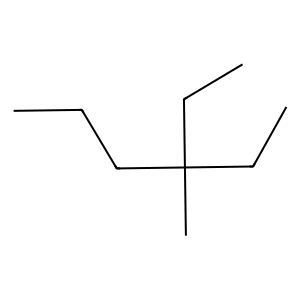


1 : COON(C)C12C3C1N32


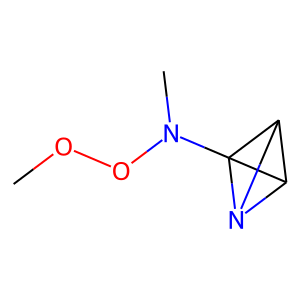


2 : CC12CC1C2(C)C(O)O


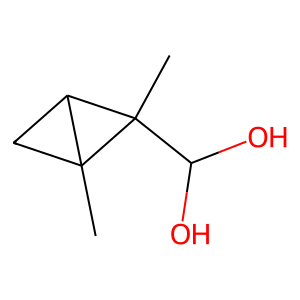


3 : CCCCC1(C)CC1O


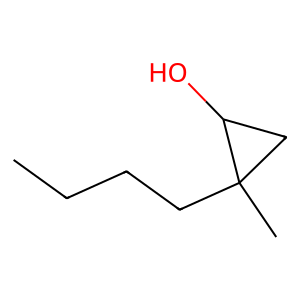


4 : CCCCC(C)(C)CC


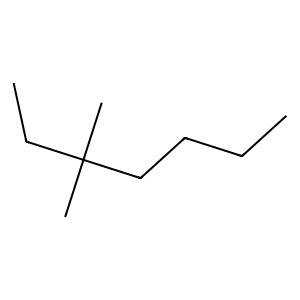


5 : CNC1(C)OOC2CC21


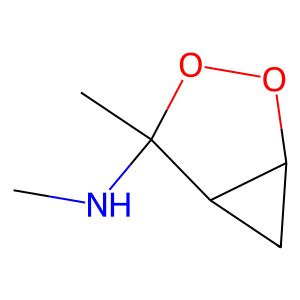


6 : CCC(C)(C)C1CC1N


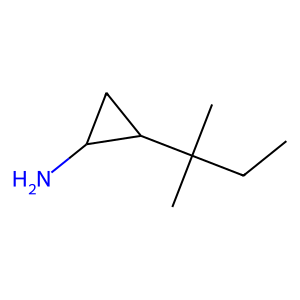


7 : CC1CC(OO)OC1O


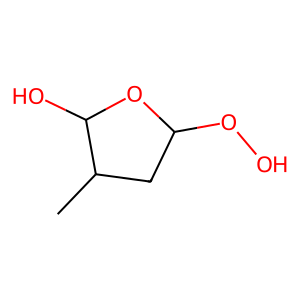


8 : COC1(C)CN1C(C)C


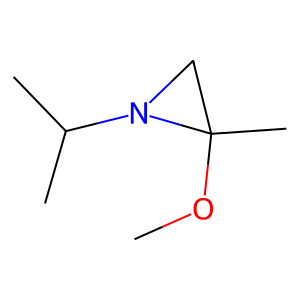


9 : C1CC23NC1(O2)C31CC1


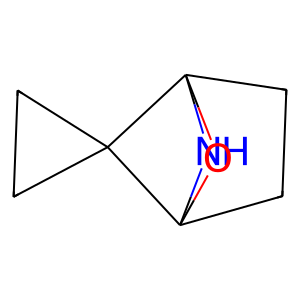


10 : CC1CC2(C)C3CCC132


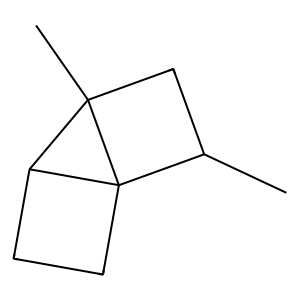


11 : CCCOC(CC)CO


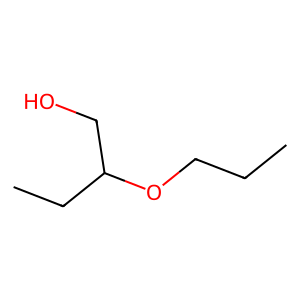


12 : CCC1CC2CCC2C1


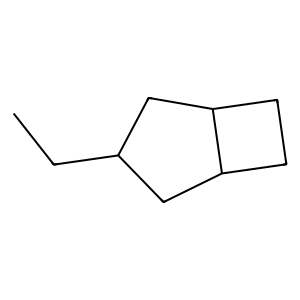


13 : CCC(C)CCCCN


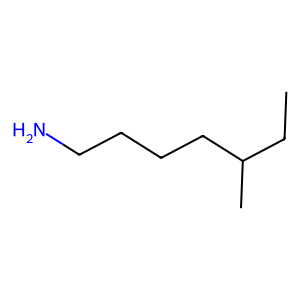


14 : CC1C2OC2N(C)C1O


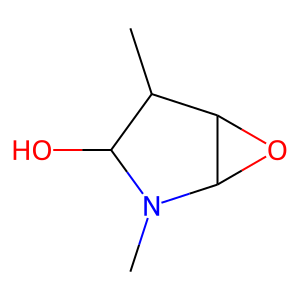


15 : CC1C2(C)CC3C2C31C


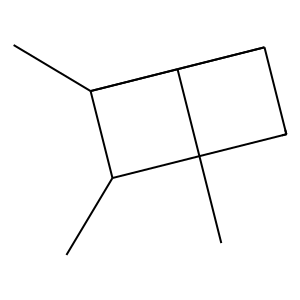


16 : CCOC1OCC1C


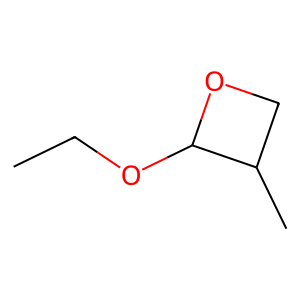


17 : CC(C)C(N)CCCO


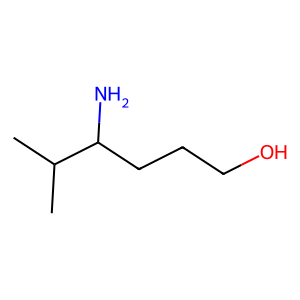


18 : CCC(CC)(CC)OC


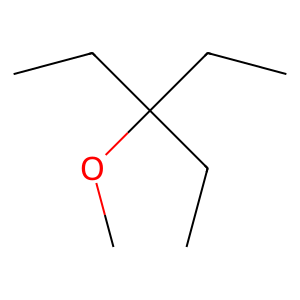


19 : CCCCONCCO


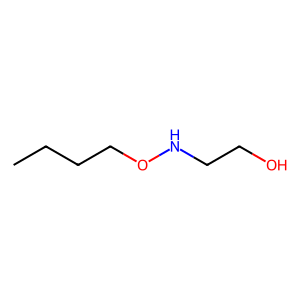


20 : CCC(O)(CN)C(C)C


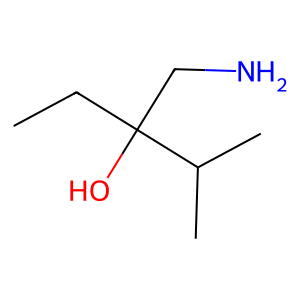


21 : OCC1CCC12CCC2


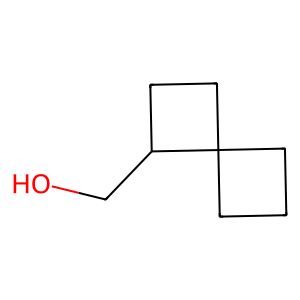


22 : CCC1OC2CC1(C)C2


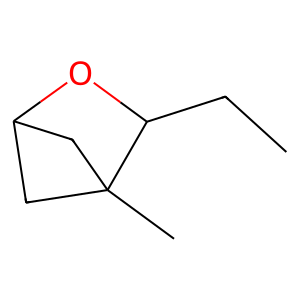


23 : CCC(C)COC(C)C


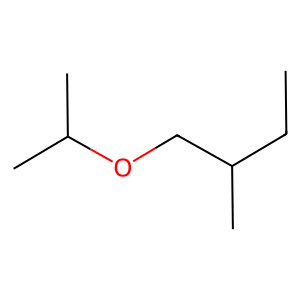


24 : CCC1C2CC1C21CC1


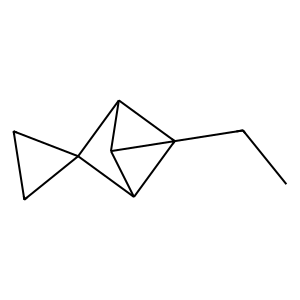


25 : CCC12C(O)C13OC23O


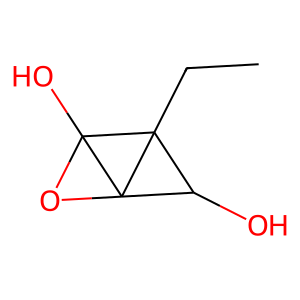


26 : CCC1CCCC1C


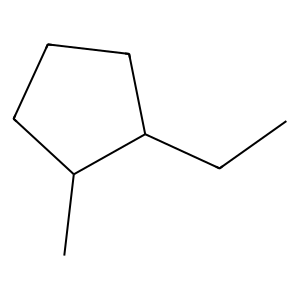


27 : CCC1C2CCC12CC


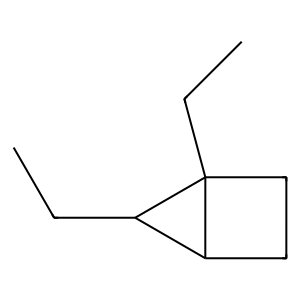


28 : CCOC(C)CCO


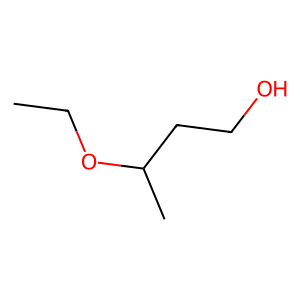


29 : CCOC1(OC)CC1C


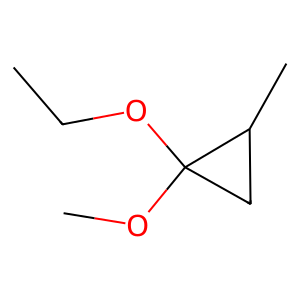

In [ ]:
for i, smiles in enumerate(smi_list) :
    print(f'\n{i} : {smiles}')
    img = Draw.MolToImage(Chem.MolFromSmiles(smiles))
    display(img)

In [ ]:
wandb.finish()

best_total_cnt,▁▆▆▆▆▆▆▆▇▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▃▃▃▃▂▃▄▂▂▂▂▃▂▂▁▂▃▂▂▃▁▂▂▃▂▃▃
total_cnt,▅▂▃▄▃▃▄▆▄▂▇▄▆█▅▄▆▆▆▂▂▃▁▆▅▅▂▆▃▂
best_total_cnt,130.0
epoch,30
epoch_train_loss,3.33009
epoch_val_loss,3.41528
total_cnt,57.0
